# Image denoising using pix2pix GAN architecture

This notebook demonstrates image denoising using conditional GAN's. Using this technique it is possible to remove noise from the image with really good results. 

## Import TensorFlow and other libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from __future__ import print_function, division
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from PIL import Image
import datetime
import os
import time
import imageio.v2 

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

from matplotlib import pyplot as plt
from IPython import display
from glob import glob
import numpy as np
import pydot
import graphviz
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os
from keras_preprocessing.image import load_img
from keras_preprocessing import image
from keras_preprocessing.image import img_to_array
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from imageio import imread
plt.rcParams['figure.figsize'] = [10, 10]

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [3]:
tf.__version__

'2.12.0'

In [4]:
print(os.listdir('D:/raw-img'))

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


## Load the dataset

In [5]:
def load_data(dataset_name, gt_dataset_name, batch_size=1):
    path_input = glob('D:/noise image/%s/*' % (dataset_name))
    path_gt = glob('D:/raw-img/%s/*' % (gt_dataset_name))

    batch_images = np.random.choice(path_input, size=batch_size)
    img_res = (150, 150,3)
    imgs_A = []  # Input images (with noise)
    imgs_B = []  # Ground Truth images (without noise)
    
    for img_path in batch_images:
        img_B = imageio.v2.imread(img_path)
        img_name = os.path.basename(img_path)
        img_gt_name = img_name.replace('__speckle_noise_.JPEG', '')# Menghapus bagian noise dari nama file
        img_gt_path = os.path.join('D:/raw-img/%s' % gt_dataset_name, img_gt_name)
        img_A = imageio.v2.imread(img_gt_path)
        
        img_A = transform.resize(img_A, img_res)
        img_B = transform.resize(img_B, img_res)
        
        imgs_A.append(img_A)
        imgs_B.append(img_B)
        
    imgs_A = np.array(imgs_A)
    imgs_B = np.array(imgs_B)
    
    return imgs_A, imgs_B


In [6]:
imgs_A, imgs_B = load_data("farfalla",'farfalla', batch_size=1)

In [7]:
def load_batch(dataset_name, gt_dataset_name, batch_size=1):
    path_gt = glob('D:/raw-img/%s/*' % (gt_dataset_name))
    path_input = glob('D:/noise image/%s/*' % (dataset_name))

    n_batches = int(len(path_gt) / batch_size)
    img_res = (150,150,3)

    for i in range(n_batches):
        batch_gt = path_gt[i*batch_size:(i+1)*batch_size]
        batch_input = path_input[i*batch_size:(i+1)*batch_size]
        imgs_A, imgs_B = [], []

        for img_path_gt, img_path_input in zip(batch_gt, batch_input):
            img_A = imageio.v2.imread(img_path_gt)
            img_B = imageio.v2.imread(img_path_input)

            img_A = transform.resize(img_A, img_res)  # Ground truth image
            img_B = transform.resize(img_B, img_res)  # Input image

            imgs_A.append(img_A)
            imgs_B.append(img_B)
            
        imgs_A = np.array(imgs_A)
        imgs_B = np.array(imgs_B)

        yield imgs_A, imgs_B


def imread(path):
    return imageio.imread(path, pilmode='RGB').astype(np.float)

In [8]:
BUFFER_SIZE = 26179
BATCH_SIZE = 256
IMG_WIDTH = 150
IMG_HEIGHT = 150
OUTPUT_CHANNELS = 3
img_shape=(IMG_WIDTH,IMG_HEIGHT,OUTPUT_CHANNELS)
inp = imgs_A[0]
re = imgs_B[0]

In [9]:
inp.shape

(150, 150, 3)

# Build the Generator

* The architecture of generator is a modified U-Net.
* Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
* Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
* There are skip connections between the encoder and decoder (as in U-Net).

In [10]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [11]:
down_model = downsample(1, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 75, 75, 1)


In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [13]:
up_model = upsample(1, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 150, 150, 1)


In [14]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[150,150,3])

    down_stack = [
        downsample(16, 4, apply_batchnorm=False), # (bs, 16, 16, 16)
        downsample(32, 4), # (bs, 8, 8, 32)
        downsample(64, 4), # (bs, 4, 4, 64)
        downsample(64, 4), # (bs, 2, 2, 64)
        downsample(64, 4), # (bs, 1, 1, 64)
  ]

    up_stack = [
        upsample(64, 4, apply_dropout=True), # (bs, 2, 2, 128)
        upsample(64, 4, apply_dropout=True), # (bs, 4, 4, 128)
        upsample(32, 4), # (bs, 8, 8, 64)
        upsample(16, 4), # (bs, 16, 16, 32)

  ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 32, 32, 1)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        if x.shape[1:3] != skip.shape[1:3]:  # Memeriksa ukuran dimensi
            x = tf.image.resize(x, skip.shape[1:3])
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
generator = Generator()

In [16]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 75, 75, 16)   768         ['input_1[0][0]']                
                                                                                                  
 sequential_3 (Sequential)      (None, 38, 38, 32)   8320        ['sequential_2[0][0]']           
                                                                                                  
 sequential_4 (Sequential)      (None, 19, 19, 64)   33024       ['sequential_3[0][0]']       

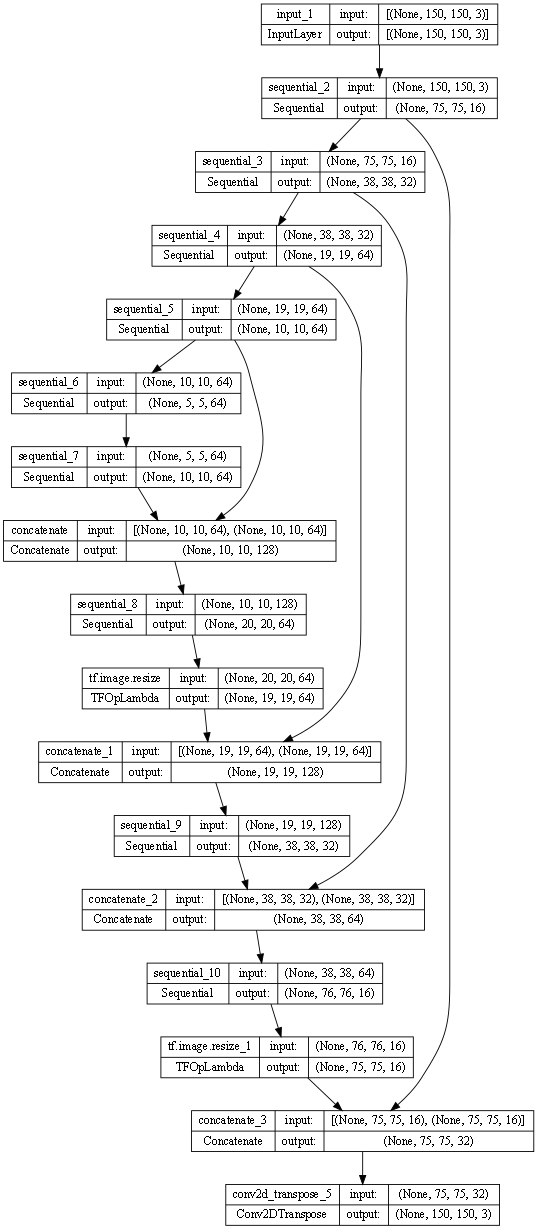

In [18]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

## Define the Generator loss

In [19]:
LAMBDA = 100

In [20]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # SSIM index 
    ssim = tf.reduce_mean(tf.image.ssim(gen_output, target, max_val=2))

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss, ssim

# Build the Discriminator

* The Discriminator is a PatchGAN.
* Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
* The shape of the output after the last layer is (batch_size, 6, 6, 1)
* Each 6x6 patch of the output classifies a 14x14 portion of the input image (such an architecture is called a PatchGAN).
* Discriminator receives 2 inputs.
  * Input image and the target image, which it should classify as real.
  * Input image and the generated image (output of generator), which it should classify as fake.
  * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [21]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[150, 150, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[150, 150, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 150, 150, 6)

    down1 = downsample(32, 4, False)(x)  # (bs, 75, 75, 32)
    down2 = downsample(64, 4)(down1)  # (bs, 38, 38, 64)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)  # (bs, 40, 40, 64)
    conv = tf.keras.layers.Conv2D(64, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (bs, 37, 37, 64)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 39, 39, 64)

    last = tf.keras.layers.Conv2D(3, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (bs, 36, 36, 3)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [22]:
discriminator = Discriminator()

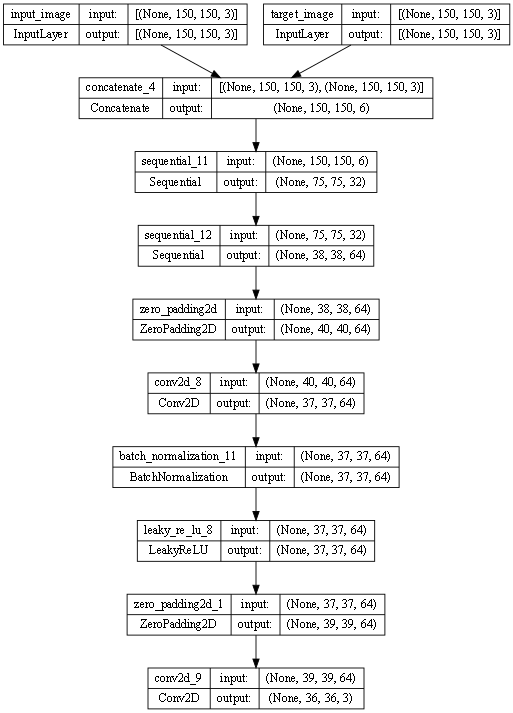

In [24]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [25]:
from keras.optimizers import Adam
optimizer = Adam(0.0001, 0.5)
disc_patch = (36,36,3)
# Build and compile the discriminator
# Number of filters in the first layer of G and D
gf = 16
df = 32

#generator.compile(loss='mae',
            #optimizer=optimizer,
            #metrics=['accuracy'])
discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

# Input images and their conditioning images
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = tf.keras.Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                 loss_weights=[1, 100],
                 optimizer=optimizer)

In [26]:
def show_images( dataset_name,gt_dataset_name,epoch, batch_i):
        
        r, c = 3, 3

        imgs_A, imgs_B = load_data(dataset_name,gt_dataset_name, batch_size=3)
        #imgs_B = np.expand_dims(imgs_B, axis=2)  # Menambahkan dimensi ke-2
        fake_A = generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [27]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.predict(test_input)
    num_images = predictions.shape[0]

    for i in range(num_images):
        plt.imshow(predictions[i])
        plt.axis('off')
        plt.savefig('image_at_epoch_{:04d}_{}.png'.format(epoch, i))
        plt.close()


In [28]:
def train( dataset_name, gt_dataset_name,epochs, batch_size=1, show_interval=10):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(dataset_name, gt_dataset_name,batch_size)):
                
                #  Train Discriminator
                

                # Condition on B and generate a translated version
                fake_A = generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

               
                #  Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                
            # Plot the progress
            if epoch%10==0:
                  print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(dataset_name,gt_dataset_name,epoch, batch_i)
        # Save the generated images at the last epoch
        test_input = imgs_B  # Use all the training images as test input
        generate_and_save_images(generator, epochs, test_input)

In [ ]:
train=train("farfalla",'farfalla',epochs=1001, batch_size=2112, show_interval=10)
train

In [30]:
def calculate_psnr(img1, img2):
    mse = tf.reduce_mean(tf.square(img1 - img2))
    psnr = tf.image.psnr(img1, img2, max_val=1.0)
    return psnr

In [31]:
psnr_values = []
for batch_i, (imgs_A, imgs_B) in enumerate(load_batch("farfalla",'farfalla', 1)):
    fake_A = generator.predict(imgs_B)
    psnr = calculate_psnr(imgs_A, fake_A)
    psnr_values.append(psnr.numpy())

average_psnr = sum(psnr_values) / len(psnr_values)
print("Average PSNR:", average_psnr)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 8ms/step
Average PSNR: [21.662]


In [32]:
psnr_values = []
for batch_i, (imgs_A, imgs_B) in enumerate(load_batch("farfalla",'farfalla', 1)):
    #fake_A = generator.predict(imgs_B)
    psnr = calculate_psnr(imgs_A, imgs_B)
    psnr_values.append(psnr.numpy())

average_psnr = sum(psnr_values) / len(psnr_values)
print("Average PSNR:", average_psnr)

Average PSNR: [18.555]
